In [1]:
import warnings
warnings.filterwarnings("ignore")  # Ignore all warnings
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from agentic_energy.schemas import BatteryParams, DayInputs, SolveRequest
from agentic_energy.reinforcementlearning.trainer import train_rllib
from agentic_energy.reinforcementlearning.evaluator import rollout_day
from agentic_energy.reinforcementlearning.config import PPOTrainSettings

Currently, RLlib incompatible with Agentics, I cannot load the dataloaders, so directly using the schemas, for battery, and use pandas to load csv files.

In [2]:
data_version = "forecast"
forecast_type = "TLLM"
duration_hours=4
soc_init=0.5
soc_min=0.0
soc_max=1.0
eta_c = 0.95
eta_d = 0.95
soc_target=0.5

In [3]:
actual_data = pd.read_csv("agentic_energy/data/Italy_data_actual.csv")
forecast_data = pd.read_csv(f"agentic_energy/data/Italy_data_{data_version}_{forecast_type}.csv")

# forecast_data = pd.read_csv(f"agentic_energy/data/Italy_data_{data_version}_{forecast_type}.csv")

In [4]:

# start_date="2019-12-01"
# end_date="2019-12-02"

In [5]:
actual_data.shape, forecast_data.shape[0]//24 - 1

((17518, 3), 363)

In [6]:
stats=forecast_data.describe()
p25, p75 = stats.loc['25%','consumption'], stats.loc['75%','consumption']
p25,p75

(np.float64(28.6120765), np.float64(37.745091))

In [7]:
# iqr_range_MW = p75 - p25
# capacity_MWh = iqr_range_kw * 4
# cmax_kw = capacity_kwh / 4
# dmax_kw = cmax_kw

battery=BatteryParams(
    capacity_MWh=43.13,
    cmax_MW=10.78,
    dmax_MW=10.78,
    soc_init=soc_init,
    soc_min=soc_min,
    soc_max=soc_max,
    eta_c=eta_c,
    eta_d=eta_d,
    soc_target=soc_target,
)
battery

BatteryParams(capacity_MWh=43.13, soc_init=0.5, soc_min=0.0, soc_max=1.0, cmax_MW=10.78, dmax_MW=10.78, eta_c=0.95, eta_d=0.95, soc_target=0.5)

In [8]:
battery.capacity_MWh

43.13

In [9]:
# Convert the whole dataset into a list of DayInputs
rng = np.random.default_rng(0)
days = [] # hold DayInputs for each day
for i in range(len(forecast_data)//24): # loop i over each day chunk

    forecast_prices, forecast_demand = forecast_data["prices"][i*24:(i+1)*24].values, forecast_data["consumption"][i*24:(i+1)*24].values
    actual_prices, actual_demand = actual_data["prices"][i*24:(i+1)*24].values, actual_data["consumption"][i*24:(i+1)*24].values

    days.append(DayInputs(
        prices_buy=actual_prices.tolist(),
        demand_MW=actual_demand.tolist(),
        prices_sell=actual_prices.tolist(),
        allow_export=True,
        dt_hours=1.0,
        prices_buy_forecast=forecast_prices.tolist(),
        demand_MW_forecast=forecast_demand.tolist(),
        prices_sell_forecast=forecast_prices.tolist(),
    ))

In [10]:
# build a test set for a specific day
from datetime import datetime
forecast_data["timestamps"] = pd.to_datetime(forecast_data["timestamps"])
test_forecast_day=forecast_data[forecast_data["timestamps"].dt.date ==  pd.to_datetime('2019-12-01').date()]

actual_data["timestamps"] = pd.to_datetime(actual_data["timestamps"])
test_actual_day=actual_data[actual_data["timestamps"].dt.date ==  pd.to_datetime('2019-12-01').date()]

In [11]:
# convert test day into DayInputs
test_days = []
for i in range(len(test_actual_day)//24):

    forecast_prices, forecast_demand = test_forecast_day["prices"][i*24:(i+1)*24].values, test_forecast_day["consumption"][i*24:(i+1)*24].values
    actual_prices, actual_demand = test_actual_day["prices"][i*24:(i+1)*24].values, test_actual_day["consumption"][i*24:(i+1)*24].values

    test_days.append(DayInputs(
        prices_buy=actual_prices.tolist(),
        demand_MW=actual_demand.tolist(),
        prices_sell=actual_prices.tolist(),
        allow_export=True,
        dt_hours=1.0,
        prices_buy_forecast=forecast_prices.tolist(),
        demand_MW_forecast=forecast_demand.tolist(),
        prices_sell_forecast=forecast_prices.tolist(),
    ))

test_days

[DayInputs(prices_buy=[65.1, 62.12, 59.05, 59.0, 56.63, 56.63, 61.66, 66.61, 73.0, 73.0, 65.0, 63.82, 62.19, 59.5, 56.99, 61.92, 65.63, 82.47, 82.79, 83.5, 78.62, 72.94, 64.53, 60.32], demand_MW=[28.68, 27.12, 25.99, 25.62, 25.66, 26.06, 28.58, 32.44, 35.25, 36.63, 36.22, 35.17, 33.26, 31.54, 31.52, 32.14, 33.53, 37.37, 38.78, 38.96, 36.4, 33.51, 30.89, 28.02], prices_sell=[65.1, 62.12, 59.05, 59.0, 56.63, 56.63, 61.66, 66.61, 73.0, 73.0, 65.0, 63.82, 62.19, 59.5, 56.99, 61.92, 65.63, 82.47, 82.79, 83.5, 78.62, 72.94, 64.53, 60.32], allow_export=True, dt_hours=1.0, prices_buy_forecast=[44.749878, 42.552708, 38.126717, 38.153713, 38.285828, 43.11862, 48.56188, 54.15712, 55.424416, 53.628986, 51.874046, 48.755173, 47.354897, 49.049633, 50.988747, 53.275772, 56.709984, 60.201057, 61.023006, 61.50245, 59.17997, 55.148796, 49.651993, 46.90073], demand_MW_forecast=[24.377789, 23.462914, 21.737377, 21.01735, 20.4696, 22.235014, 23.999521, 26.921799, 28.375935, 29.094069, 29.2466, 27.908028, 2

In [12]:
train_days = days
train_days

[DayInputs(prices_buy=[45.82, 44.16, 42.24, 39.29, 36.0, 41.99, 42.25, 44.97, 45.0, 44.94, 45.02, 45.71, 46.7, 43.98, 44.96, 47.53, 49.91, 54.3, 51.91, 51.38, 49.2, 45.73, 44.84, 38.11], demand_MW=[22.98, 21.81, 20.76, 19.97, 19.49, 19.84, 21.1, 22.1, 22.4, 23.59, 24.37, 24.96, 25.06, 23.9, 23.49, 23.76, 25.24, 29.1, 30.35, 30.97, 30.34, 28.82, 26.54, 24.05], prices_sell=[45.82, 44.16, 42.24, 39.29, 36.0, 41.99, 42.25, 44.97, 45.0, 44.94, 45.02, 45.71, 46.7, 43.98, 44.96, 47.53, 49.91, 54.3, 51.91, 51.38, 49.2, 45.73, 44.84, 38.11], allow_export=True, dt_hours=1.0, prices_buy_forecast=[45.970184, 45.73973, 44.22332, 42.651825, 41.65599, 45.653225, 50.93553, 58.98442, 62.25169, 62.049282, 60.599857, 56.859856, 54.864773, 56.092606, 58.104904, 60.89053, 64.216934, 65.604836, 66.56846, 68.158714, 66.2336, 61.93369, 56.555878, 51.320816], demand_MW_forecast=[23.92131, 22.560665, 21.96416, 21.188221, 19.94692, 21.332676, 22.449694, 24.573563, 27.04342, 28.272095, 28.993662, 27.866068, 28.12

In [13]:


# train_days = days[:-1]
# test_day = days[-1]

# solve request for evaluation
eval_req = SolveRequest(battery=battery, day=test_days[0], solver="RL", solver_opts={"lambda_smooth": 0.00})


In [14]:
# PPO training hyperparameters
settings = PPOTrainSettings(
    num_env_runners=4, # working on 4 cores, 4 cores left for otherd
    rollout_fragment_length=24, # 1 full day per episode
    gamma=0.99, 
    lr=1e-3,
    train_batch_size=24*64,
    minibatch_size=24*24,
    num_epochs=5,                 # bump to 10 if stable
    clip_param=0.2,
    vf_clip_param=10.0,
    evaluation_interval=2,
    evaluation_episodes=20,
)

ckpt = train_rllib(
    eval_req, days,
    settings = settings,
    num_iterations=200,
    obs_mode="forecast", obs_window=24
)

:job_id:01000000
:actor_name:RolloutWorker


:job_id:01000000
:actor_name:RolloutWorker


:actor_name:RolloutWorker
:actor_name:RolloutWorker


:actor_name:RolloutWorker
:actor_name:RolloutWorker


:actor_name:RolloutWorker


:actor_name:RolloutWorker
2026-02-05 16:24:23,347	WARNING util.py:61 -- Install gputil for GPU system monitoring.


TensorBoard logdir: runs/rllib_battery/PPO_battery_Italy
[ITER   1] trainR=-0.77 (EMA=-0.77)  evalR=NA  KL=0.016✅  Entropy=1.418  Vexp=0.008⚠
        notes: Value net weak → adjust value loss coeff or lr
[TRAIN] ep#   24  R=  20.222 len=24
[TRAIN] ep#   24  R=   4.611 len=24
[TRAIN] ep#   24  R=  11.902 len=24
[TRAIN] ep#   24  R=  -4.210 len=24
[ITER   2] trainR=10.67 (EMA=0.37)  evalR=NA  KL=0.017✅  Entropy=1.454  Vexp=0.003⚠
        notes: Value net weak → adjust value loss coeff or lr
[TRAIN] ep#   48  R=  65.043 len=24
[TRAIN] ep#   48  R=  12.056 len=24
[TRAIN] ep#   48  R=  78.270 len=24
[TRAIN] ep#   48  R=   7.603 len=24
[ITER   3] trainR=29.16 (EMA=3.25)  evalR=NA  KL=0.012✅  Entropy=1.483  Vexp=-0.020⚠
        notes: Value net weak → adjust value loss coeff or lr
[TRAIN] ep#   24  R=  85.008 len=24
[ITER   4] trainR=41.74 (EMA=7.10)  evalR=NA  KL=0.018✅  Entropy=1.366  Vexp=-0.005⚠
        notes: Value net weak → adjust value loss coeff or lr
[TRAIN] ep#   72  R=  81.951 len

In [15]:
ckpt ="runs/rllib_battery"

In [16]:
eval_req = SolveRequest(battery=battery, day=test_days[0], solver="RL", solver_opts={"lambda_smooth": 0.00})
res = rollout_day(ckpt, eval_req, obs_mode="forecast", obs_window=24)
res


2026-02-05 16:30:41,740	WARNING util.py:61 -- Install gputil for GPU system monitoring.


Rollout done. Episode return (scaled): 147.940 | Cost: 49624.023


SolveResponse(status='rllib_policy', message=None, objective_cost=49624.0234375, charge_MW=[0.0, 2.075035572052002, 5.70236873626709, 8.024985313415527, 8.431109428405762, 5.3151774406433105, 0.0, 0.0, 0.0, 0.0, 0.0, 10.779999732971191, 10.779999732971191, 10.779999732971191, 8.027880668640137, 1.13509202037676e-11, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], discharge_MW=[6.180931091308594, 0.0, 0.0, 0.0, 0.0, 0.0, 0.21208319067955017, 10.779999732971191, 10.779999732971191, 10.779999732971191, 3.8799288272857666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4472501873970032, 10.779999732971191, 10.779999732971191, 10.779999732971191, 8.186249732971191, 1.078070965832012e-11, 1.078070965832012e-11, 7.712053218256187e-12], import_MW=[22.499069213867188, 29.195035934448242, 31.692367553710938, 33.64498519897461, 34.09111022949219, 31.37517738342285, 28.367916107177734, 21.65999984741211, 24.470001220703125, 25.85000228881836, 32.34007263183594, 45.94999694824219, 44.03999710083008, 42.31999969482422, 39.547

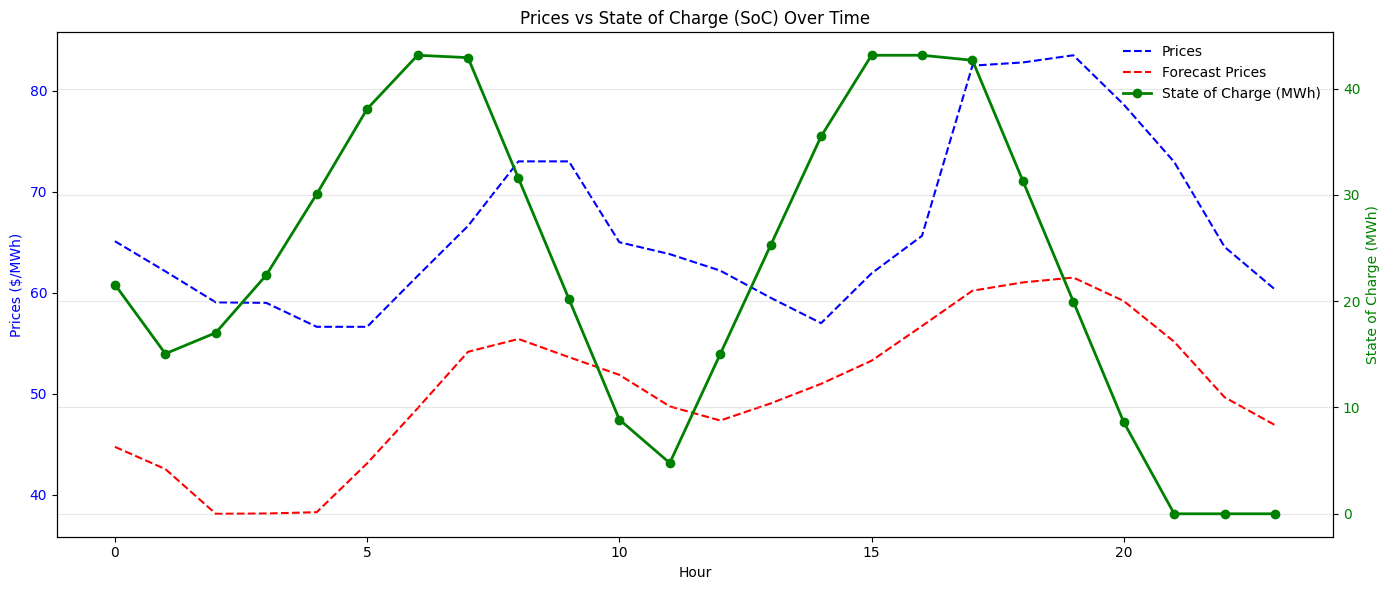

In [17]:
import numpy as np
import matplotlib.pyplot as plt

hours = np.arange(24)
fig, ax1 = plt.subplots(figsize=(14, 6))

# --- Primary axis (Prices) ---
ax1.plot(hours, eval_req.day.prices_buy, '--b', label='Prices')
ax1.plot(hours, eval_req.day.prices_buy_forecast, '--r', label='Forecast Prices')
ax1.set_xlabel('Hour')
ax1.set_ylabel('Prices ($/MWh)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# --- Secondary axis (State of Charge) ---
ax2 = ax1.twinx()
ax2.plot(hours, np.array(res.soc[:-1]) * battery.capacity_MWh,
         '-og', label='State of Charge (MWh)', linewidth=2, markersize=6)
ax2.set_ylabel('State of Charge (MWh)', color='g')
ax2.tick_params(axis='y', labelcolor='g')


# --- Legends ---
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='best', frameon=False)

plt.title('Prices vs State of Charge (SoC) Over Time')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [18]:
# import numpy as np
# import matplotlib.pyplot as plt

# hours = np.arange(24)

# # Data arrays
# load = np.array(eval_req.day.demand_kw)
# charge = np.array(res.charge_kw)
# discharge = np.array(res.discharge_kw)
# import_kw = np.array(res.import_kw)
# export_kw = np.array(res.export_kw) if getattr(eval_req.day, "allow_export", False) else np.zeros_like(load)

# # Flip battery convention for visualization
# charge_vis = -charge       # show charge below 0
# discharge_vis = discharge  # show discharge above 0

# # ---------------------- PLOT ----------------------
# fig, ax = plt.subplots(figsize=(14, 6))

# # --- positive side stacking (Import + Discharge + Export) ---
# # import is base layer
# ax.bar(hours, import_kw, width=0.5, color='orange', label='Import (+)')
# # discharge stacked on top of import
# ax.bar(hours, discharge_vis, width=0.5, bottom=import_kw, color='indianred', label='Discharge (+)')
# # export stacked on top (for clear separation)
# ax.bar(hours, export_kw, width=0.5, bottom=import_kw + discharge_vis, color='limegreen', alpha=0.7, label='Export (+)')

# # --- negative side stacking (Charge only) ---
# ax.bar(hours, charge_vis, width=0.5, color='cornflowerblue', label='Charge (−)')

# # --- Load as line ---
# ax.plot(hours, load, '-ok', linewidth=2, markersize=5, label='Load (kW)')

# # Formatting
# ax.axhline(0, color='black', linewidth=0.8)
# ax.set_ylabel("Power (kW)")
# ax.set_xlabel("Hour")
# ax.set_title("Power Balance Components (Charge ↓  |  Discharge ↑)")
# ax.legend(ncol=3, loc='upper left', fontsize=9)
# ax.grid(alpha=0.3)

# plt.tight_layout()
# plt.show()


In [19]:
total_objective_value = 0
for day_result in [res]:
    total_objective_value += day_result.objective_cost
print(f"Total Objective Value over all days: ${total_objective_value:.2f} for {len([res])} days")

Total Objective Value over all days: $49624.02 for 1 days


In [20]:
from typing import Sequence, Optional
def cost_from_soc(
    soc: Sequence[float],
    prices_buy: Sequence[float],
    demand_MW: Sequence[float],
    *,
    battery: BatteryParams,
    prices_sell: Optional[Sequence[float]] = None,
    allow_export: bool = False,
    dt_hours: float = 1.0,
):
    soc = np.asarray(soc, dtype=float)
    assert len(soc) >= 2, "SOC must include at least t=0 and t=1"
    T = len(soc) - 1

    prices_buy  = np.asarray(prices_buy, dtype=float)
    demand_MW   = np.asarray(demand_MW, dtype=float)
    assert len(prices_buy) == T and len(demand_MW) == T

    if prices_sell is None:
        prices_sell = prices_buy
    prices_sell = np.asarray(prices_sell, dtype=float)
    assert len(prices_sell) == T

    # Per-step energy change in MWh
    dE = (soc[1:] - soc[:-1]) * battery.capacity_MWh

    # Recover charge/discharge MW from SOC deltas and efficiencies
    charge_MW    = np.maximum(dE, 0.0) / (battery.eta_c * dt_hours)
    discharge_MW = np.maximum(-dE, 0.0) * (battery.eta_d / dt_hours)

    # Enforce hardware limits
    charge_MW    = np.minimum(charge_MW,    battery.cmax_MW)
    discharge_MW = np.minimum(discharge_MW, battery.dmax_MW)

    # Grid net load
    net = demand_MW + charge_MW - discharge_MW
    imp = np.maximum(net, 0.0)
    exp = np.maximum(-net, 0.0) if allow_export else np.zeros_like(net)

    # Cost (buy imports, optionally credit exports)
    cost = float(np.sum(prices_buy * imp * dt_hours) - np.sum(prices_sell * exp * dt_hours))

    out = {
        "charge_MW": charge_MW,
        "discharge_MW": discharge_MW,
        "import_MW": imp,
        "export_MW": exp,
        "net_MW": net,
        "objective_cost": cost,
    }
    return out

out = cost_from_soc(
    soc = res.soc,
    prices_buy=eval_req.day.prices_buy,
    demand_MW=eval_req.day.demand_MW,
    battery=battery,
    prices_sell=eval_req.day.prices_sell,
    allow_export=True,
    dt_hours=1
)
out["objective_cost"]

49624.022220744904

In [21]:
out["export_MW"]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.])

In [22]:
# help me create a dataframe to csv to store the results that we see in the plots
import pandas as pd
df = pd.DataFrame()
df["prices_actual"] = eval_req.day.prices_buy
df["prices_forecast"] = eval_req.day.prices_buy_forecast
df["actual_demand"] = eval_req.day.demand_MW
df["forecast_demand"] = eval_req.day.demand_MW_forecast
df["soc"] = res.soc[:-1]
df["charge_MW"] = out["charge_MW"]
df["discharge_MW"] = out["discharge_MW"]
df["import_MW"] = out["import_MW"]
df["export_MW"] = out["export_MW"]

# df.to_csv(f"rlPPO_actual_perfect.csv", index = False)
df.to_csv(f"rlPPO_{data_version}_{forecast_type}.csv", index = False)

In [23]:
df["profit_step"] = (df["discharge_MW"] - df["charge_MW"]) * df["prices_actual"] * 1
total_profit = df["profit_step"].sum()

print("Total arbitrage profit:", total_profit)

Total arbitrage profit: 2139.3163792550927


In [24]:
res.soc[:-1]

[0.5,
 0.34914809465408325,
 0.39485371112823486,
 0.5204565525054932,
 0.6972183585166931,
 0.8829256296157837,
 1.0,
 0.9948238730430603,
 0.7317270040512085,
 0.4686301350593567,
 0.2055332511663437,
 0.11083964258432388,
 0.3482845723628998,
 0.5857294797897339,
 0.8231744170188904,
 1.0,
 1.0,
 0.9890844225883484,
 0.7259875535964966,
 0.4628906548023224,
 0.1997937709093094,
 0.0,
 0.0,
 0.0]

In [ ]:
2173.26, 2024.25, 2029.33, 2139.32